In [8]:
import sys 
#sys.path.append("codes/modules") # add custom Vibe 's modules
sys.path.append('../..') # add standard 's modules
sys.path.append('../modules')

import pyfesom as pf
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import numpy as np
from netCDF4 import Dataset
import os
import time

In [9]:
# ==============================================================================
# Running this file loads tracers from old FESOM-REcoM2 output file (oce.mean.nc)
# and saves each tracer in an individual file
#
#  Input:
#  - mesh_id: Name of mesh, will be added to the netcdf name
#  - meshpath: Speciefies where the target mesh is stored
#  - save_netcdf: If true, netcdf will be created
#  - delete_old_netcdf: If a netcdf file with the same name exists, a new cannot 
#    be made. If set to true, an old netcdf with the same name will be deleted
#
#  Output:
#  - netcdf file for each tracer in the old file
#
#  During running, keep an eye on the output in the terminal, to see if it 
#  makes sense. 
#
# ==============================================================================

In [10]:
# Loading mesh for run

mesh_id    = 'meshArc4.5'
meshpath   = '/home/hbkoziel/pyfesom/data/mesh/'+mesh_id+'/'            # Defining path where mesh is stored
mesh = pf.load_mesh(meshpath, usepickle=True, get3d=True)                                    # Loading mesh, stores it in mesh.****  
#mesh = pf.fesom_mesh(meshpath, get3d=True)
#mesh.zlevs = -mesh.zlevs                                            # Depth is made negative

tracername = 'VNF'
first_year = 1985
last_year  = 2015
years      = np.arange(first_year,last_year+1,1)
runid	= 'Arc12'

/home/hbkoziel/pyfesom/data/mesh/meshArc4.5/pickle_mesh
2
The usepickle == True)
The pickle file for python 2 exists.
The mesh will be loaded from /home/hbkoziel/pyfesom/data/mesh/meshArc4.5/pickle_mesh


In [11]:
mesh


FESOM mesh:
path                  = /gfs2/work/hbkvsk12/mesh/meshArc4.5
alpha, beta, gamma    = 50, 15, -90
number of 2d nodes    = 753179
number of 2d elements = 1480268
number of 3d nodes    = 16950142

        

In [12]:
# ==============================================================================
# Settings for netcdf file

save_netcdf       = True                                            # Saves the interpolated field in netcdf file
delete_old_netcdf = True                                            # If a netcdf file with the same name exists it will be deleted
input_directory  = '/scratch/usr/hbkoziel/'+runid+'/netcdf/'       # Where the netcdf is saved
output_directory  = '/scratch/usr/hbkoziel/'+runid+'/netcdf/'
plot_netcdf       = True                                           # Reads DIN from the created netcdf file, else it plots the interpolated field (should be the same)

In [13]:
for ind in range(0,len(years)):
    netcdf_name       = tracername+'.'+str(years[ind])+'.monthly.nc'
    print years[ind]
    # ==============================================================================
    # Loading data

    ncfile1	= input_directory+'tr01.'+str(years[ind])+'.monthly.nc'
    f1	= Dataset(ncfile1,'r')
    
    ncfile2	= input_directory+'w.'+str(years[ind])+'.monthly.nc'
    f2	= Dataset(ncfile2,'r')
    
    ncfile3	= input_directory+'mixlay.'+str(years[ind])+'.monthly.nc'
    f3	= Dataset(ncfile3,'r')
    
    tracer = np.zeros((len(range(0,12,1)),len(mesh.x2)))
    tracer1 = np.zeros((len(range(0,12,1)),len(mesh.x2)))
    tracer2 = np.zeros((len(range(0,12,1)),len(mesh.x2)))
    for mo in range(0,12,1):
        din	= f1.variables['tr01'][mo,:]
        w	= f2.variables['w'][mo,:]
        mld	= f3.variables['mixlay'][mo,:]
        t = np.zeros(len(mesh.x2))
        d = np.zeros(len(mesh.x2))
        ww = np.zeros(len(mesh.x2))
        for i in range(0,len(mesh.x2)):
            if ((mesh.y2[i] >= 70) & (mesh.topo[i]>500)):
                # print 'derive Upward Nitrate Fluxes'
                ind_mld = np.max(np.argwhere(mesh.zlevs <= mld[i]))
                ind_depth = np.array(mesh.n32[i,ind_mld]) # depth max 580m
                t[i] = (din[ind_depth] * w[ind_depth] * 3600 * 24 * 30) 
                d[i] = din[ind_depth]
                ww[i] = w[ind_depth] * 3600 * 24 * 30
                # conversion fron micro mmole /m2 /s1 -> mmole /m2 /month
        tracer[mo,:] = t
        tracer1[mo,:] = d
        tracer2[mo,:] = ww
    tracershape = np.shape(tracer)
    
    # ==============================================================================
    # Testing if a netcdf file with the same name exists, if yes, it must be removed
    # to save a new one.

    if os.path.isfile(output_directory+netcdf_name) and delete_old_netcdf:
      os.remove(output_directory+netcdf_name)
      print "The netcdf file "+netcdf_name+" has been deleted to make room for your file of the same name."
    elif os.path.isfile(netcdf_name):
      statement = "The netcdf file "+netcdf_name+" already exists! It must be removed for a new one to be created. This can be done by changing your settings."
      sys.exit(statement)

    if not os.path.isdir(output_directory):
      os.makedirs(output_directory)
      print 'Directory '+output_directory+' has been created'

    # ==============================================================================
    # Creating netcdf file
    if save_netcdf:  
      import time
      w_nc_fid = Dataset(output_directory+netcdf_name, 'w', format='NETCDF4_CLASSIC')      # Create and open new netcdf file to write to
      w_nc_fid.description = 'Vertical Nitrate fluxes at the base of the MLD' 
      w_nc_fid.history     = 'Created ' + time.ctime(time.time())

      nod2d    = w_nc_fid.createDimension('nod2d', mesh.n2d)               # Create dimension: number of 3d nodes
      time	   = w_nc_fid.createDimension('time', tracershape[0]) 

      w_nc_var = w_nc_fid.createVariable(tracername, 'f8',('time','nod2d'))           # 'DIN' is name of saved variable                                    # 'f8' sets presicion to 64-bit floating point
      w_nc_var.setncatts({'long_name': u'Vertical Nitrate fluxes',\
                          'units': u'mmol /m2 /month'})
      w_nc_fid.variables[tracername][:] = tracer 
    
      w_nc_var = w_nc_fid.createVariable('DIN', 'f8',('time','nod2d'))           # 'DIN' is name of saved variable                                    # 'f8' sets presicion to 64-bit floating point
      w_nc_var.setncatts({'long_name': u'DIN',\
                          'units': u'mmol /m3'})
      w_nc_fid.variables['DIN'][:] = tracer1 
        
      w_nc_var = w_nc_fid.createVariable('w', 'f8',('time','nod2d'))           # 'DIN' is name of saved variable                                    # 'f8' sets presicion to 64-bit floating point
      w_nc_var.setncatts({'long_name': u'w',\
                          'units': u'm /month'})
      w_nc_fid.variables['w'][:] = tracer2 
    
      w_nc_fid.close()                                                     # close the new file                

      cwd = os.getcwd()
      print "New netcdf file (",netcdf_name,") has been created."
      print "Location: "+output_directory
    else:
      print 'You have specified not to save your field in netcdf file'

1985
The netcdf file VNF.1985.monthly.nc has been deleted to make room for your file of the same name.
New netcdf file ( VNF.1985.monthly.nc ) has been created.
Location: /scratch/usr/hbkoziel/Arc12/netcdf/
1986
The netcdf file VNF.1986.monthly.nc has been deleted to make room for your file of the same name.
New netcdf file ( VNF.1986.monthly.nc ) has been created.
Location: /scratch/usr/hbkoziel/Arc12/netcdf/
1987
The netcdf file VNF.1987.monthly.nc has been deleted to make room for your file of the same name.
New netcdf file ( VNF.1987.monthly.nc ) has been created.
Location: /scratch/usr/hbkoziel/Arc12/netcdf/
1988
The netcdf file VNF.1988.monthly.nc has been deleted to make room for your file of the same name.
New netcdf file ( VNF.1988.monthly.nc ) has been created.
Location: /scratch/usr/hbkoziel/Arc12/netcdf/
1989
The netcdf file VNF.1989.monthly.nc has been deleted to make room for your file of the same name.
New netcdf file ( VNF.1989.monthly.nc ) has been created.
Location: /

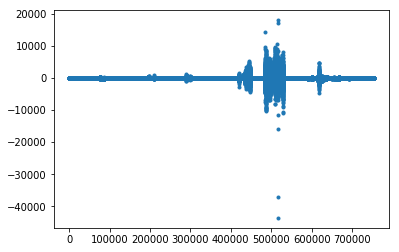

In [23]:
plt.plot(t,'.')

In [21]:
w[ind_depth] * 3600 * 24 * 30

-14.858354974421673

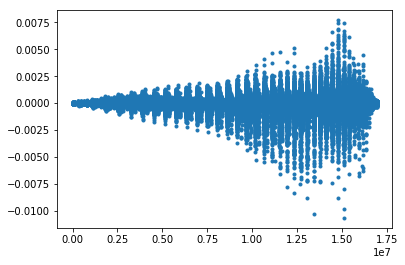

In [24]:
plt.plot(w,'.')

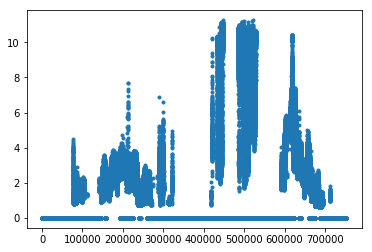

In [25]:
plt.plot(d,'.')